# Group 3 - Personal Informatics
Benjamin, Jeremy, Martin, William, Serena, Stanley

**Important**: This notebook relies on a number of packages to be installed in order to run, and the notebook should be run from the relevant Github repository that includes the raw data (which is inputted and cleaned in this notebook).

In [67]:
#Python native
import math
import datetime
from datetime import datetime
from collections import defaultdict


#Anaconda native
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import statsmodels as st
import statsmodels.api as sm
import scipy.stats as scs
from scipy import stats
from pandas import DataFrame
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from matplotlib.pylab import rcParams


#Non-native packages
import xmltodict
from pmdarima.arima import auto_arima

#Stop warnings
import warnings
warnings.filterwarnings("ignore")

#Matplotlib plot type
%matplotlib inline

## Introduction

#### Driving Question
The core goal of this analysis is to consider and answer the question: *What is the difference between the Althoff et. al (2017) calculation of step coutns with one that requires 10-hours of the day with steps for a small number of users?*

Step data was collected from a number of anonimysed participants. Based on the collection device used, this data was either back-dated over a number of years or calculated for a period of approximately one week during the collection process. In this product notebook, we provide multiple methods for reading in step-data counts from different sources, and then present a number of aggregation methods that may be used to account for outliers and non-adherence problems. Finally, we compare the impact of these filtering and aggregation processes on both numeric and graphical analysis of step-count data. All code in the notebook is written in the Python language, and the raw data is stored in the relevant Github repository.

## Hypothesis

Our hypothesis is the manner in which we count the steps would have an impact on the analysis of the step data

## Data Input and Processing

Step data was collected in three different forms, corresponding to three potential apps that participants used to report their step count data. For each of these, the data is stored in a different format and so we require a different extraction process. First, we highlight the process of data collection and the ethical considerations involved.

### Ethical Considerations

**Anonymistaion of Participants** <br /> 

For a participant to have their data be considered anonymised, their data would have to be stripped of all potential identifiers to them. For example, name, email (with respect to our data collection method). This ensured that there would be no way to allow future re-linking of the participant and their data. When the data is properly anonymised, even the group using the data would not be able to identify the original owner of the data by looking at the data. <br />
To acheive this, our group had participants email their data to our Ethics Manager (Jeremy). Here, he added an ID number for identification purposes (to the group) while ensuring that there was no digital footprint remaining in the step data that would tie it back to the data owner before giving the group access to it. 

**Validity of Data** <br /> 

For each dataset, we conducted non-parametric statistical tests. This was to ascertain their validity, especially against our base datasets of User 1 and User 2. We utilised methods such as rank correlation, comparison across standard means and normality tests. We have found that participant data with more than 200 values are statistically significant, as they have the same distribution and are positively correlated to each other (although with a weak/small to medium relationship).

**Informed Constent** <br /> 
Informed Consent is process in which researchers (us carrying out the study) obtains permission from the participant to use their data in the agreed upon manner.
To ensure all our participants have provided us with their informed consent, they were required to fill in a questionaire that entailed the what would happen in the study and how their data would be used and agree to the terms of their data use.

### Data Management

**Maintaining Raw Data** <br />

Raw data is data collected straight from it's source (the participants). The raw (but anonymised data) was stored on the GitHub repository under **data** here, it contained files of the raw but anonymised data and a file containing the cleaned data (Data in our desired format). 

**Managing Stored Data** <br />

As mentioned in **Maintaining Raw Data**, the anonymised data is stored on the Github Repository while the raw and un-anonymised data was stored locally on Jeremy's hardrive.

**Deletion Processes** <br />

In the questionaire that participants responded to, it was stated that their data would be kept for up to 6 months after the conclusion of the study. After which, raw data from the participants would be deleted.

### Reading Step Data

#### QS Access
The first app which participants could use was [QSAccess](https://apps.apple.com/us/app/qs-access/id920297614). This app exports step-count data into a CSV format, and each measurement is taken over an hour-interval. If there were no steps in the hour, a 'zero' is reported. For each of the following functions, a filepath is read in (as a character string), and a Pandas dataframe is outputted. The precise format of these dataframes will be explained.

In [68]:
def read_QS_data(filename):
    #Read in CSV file
    dat = pd.read_csv(filename)
    #Extract datetime information
    dat["Datetime"] = pd.to_datetime(dat["Start"], format = '%d-%b-%Y %H:%M')
    dat["Date"] = dat["Datetime"].dt.date
    dat["Hour"] = dat["Datetime"].dt.hour
    #Format columns
    dat = dat[["Date", "Hour", "Steps (count)"]]
    dat.columns = ["Date", "Hour", "Steps"]
    
    return dat

#### Pacer
The second app was [Pacer](https://www.mypacer.com/), available on iOS and Android devices. This app also allowed the exporting of data as a csv file, and gave the number of steps in every 15 minute interval. In order to keep consistency, we aggregate over each of the intervals to achieve a total number of steps per hour.

In [69]:
def read_Pacer_data(filename):
    #Read in the data
    dat = pd.read_csv(filename)
    #Select necessary columns
    dat = dat[["date","steps"]]
    #Extract datetime data
    dat["datetime"] = pd.to_datetime(dat["date"], format = '%m/%d/%Y, %H:%M:%S %z')
    dat["Date"] = dat["datetime"].dt.date
    dat["Hour"] = dat["datetime"].dt.hour
    dat["Min"] = dat["datetime"].dt.minute
    #Aggregate over the hours
    dat = dat.groupby(["Date","Hour"])["steps"].agg("sum").reset_index()
    #Relabel columns
    dat.columns = [["Date", "Hour", "Steps"]]
    
    return dat

#### Apple Health

Finally, participants could export step-count data from [Apple Health](https://www.apple.com/au/ios/health/), which is native to iOS devices. This data is stored in XML format, so it takes somewhat more extraction and pre-processing. The step-counts are also stored as non-homogenous intervals, which means that we approximate the hourly step-count by *resampling* on the hour at which the observation was recorded. Since the intervals during periods of activity are significantly shorter than an hour (usually 10 minutes), this is a reasonable approximation to make.

In [70]:
def read_XML_data(filename):
    #Read in XML file
    with open(filename, 'r') as xml_file:
        input_data = xmltodict.parse(xml_file.read())
    #Extract record data from XML
    record_list = input_data['HealthData']['Record']
    df = pd.DataFrame(record_list)
    #Convert dates to datetime objects and steps to numeric
    date_format = '%Y-%m-%d %H:%M:%S %z'
    df['@startDate'] = pd.to_datetime(df['@startDate'], format = date_format)
    df['@endDate'] = pd.to_datetime(df['@endDate'], format = date_format)
    df['@value'] = pd.to_numeric(df['@value'])
    #Sum up values for each hour
    dat = df.resample("H", on="@startDate").sum().reset_index()
    #Extract date and hour information, and relabel columns
    dat["Date"] = dat["@startDate"].dt.date
    dat["Hour"] = dat["@startDate"].dt.hour
    dat["Steps"] = dat["@value"]
    dat = dat[["Date","Hour","Steps"]]
    
    return dat

#### Cleaned Data

Finally we introduce a method to read in the cleaned data. This is useful if one wants to do pre-processing before all of their analysis, and then we can simply read in the cleaned csv file each time. The data structure is of the following form: each observation corresponds to a an hour of the day. The columns are *Date* (stored as a date-time object), *Hour* (stored as an integer) and *Steps* (stored as a float, for technical reasons discussed later). When reading in pre-cleaned data, all one has to do is convert the *Date* column to a datetime object.

In [71]:
def read_CLEAN_data(filename):
    #Read in CSV file
    dat = pd.read_csv(filename)
    #Convert datetimes
    dat["Date"] = pd.to_datetime(dat["Date"], format = '%Y-%m-%d').dt.date
    
    return dat

### Data Input Pipeline

Finally, we create one function that collate all of these and can be called on any of the datasets. This function takes two parameters; the filepath of the dataset and the type of data, from the list `["qs","pacer","xml","clean"]`

In [72]:
def read_step_data(filename, read_type):
    read_type = read_type.lower()
    print("reading: " + filename)
    if read_type == "pacer":
        return read_Pacer_data(filename)
    elif read_type == "qsaccess" or read_type == "qs":
        return read_QS_data(filename)
    elif read_type == "xml":
        return read_XML_data(filename)
    elif read_type == "clean" or read_type == "cleaned":
        return read_CLEAN_data(filename)
    else:
        raise Exception("Not a valid file type to read! Use pacer, qs, xml or clean")

We present an example, using the data from User1. We print out the first 10 rows of the cleaned data.

In [73]:
read_step_data("data/Participant_ID_A/User1.csv", "qs").head(10)

reading: data/Participant_ID_A/User1.csv


,Date,Hour,Steps
0,2014-12-07,9,941.0
1,2014-12-07,10,408.0
2,2014-12-07,11,157.0
3,2014-12-07,12,1017.0
4,2014-12-07,13,0.0
5,2014-12-07,14,0.0
6,2014-12-07,15,137.0
7,2014-12-07,16,0.0
8,2014-12-07,17,33.0
9,2014-12-07,18,0.0


### Creating Data Frames

We read in the data from each participant into a separate Pandas dataframe. This will form the basis for our further analysis. 

**Important:** This raw data is saved in the Github file, which must be attached to this notebook for it to run. We store the names of each of the dataframes in a file called `userfilenames.txt` in the datafile, along with the formats of each of the files.

In [74]:
DATAFILEPATH = "data/"
file = open(DATAFILEPATH + "userfilenames.txt", "r")
names = file.readline().strip("\n").split(",")
formats = file.readline().strip("\n").split(",")

dfs = [read_step_data(DATAFILEPATH + names[i], formats[i]) for i in range(len(names))]

reading: data/Participant_ID_A/User1.csv
reading: data/Participant_ID_B/User2.csv
reading: data/Participant_ID_01/DetailedSteps_2020_10_24_1932.csv
reading: data/Participant_ID_02/export.xml
reading: data/Participant_ID_03/export.xml
reading: data/Participant_ID_06/DetailedSteps_2020_11_09_1153.csv
reading: data/Participant_ID_07/Health Data.csv
reading: data/Participant_ID_C/User3.csv


## Introductory EDA

### Basic Statistics

Before implementing any adherence measures, we want to get an idea for the structure of our data, particularly accounting for the differences in size of each dataset in our list. We start by counting some basic statistics for each of our datasets.

In [75]:
d = {'# Entries': [df.shape[0] for df in dfs],
     'Avg': [ df.loc[:, ['Steps']].mean().values[0] for df in dfs],
     'Median':[ df.loc[:, ['Steps']].median().values[0] for df in dfs],
     'Zero %': [ (df.loc[:, ['Steps']] == 0).sum().values[0] for df in dfs]}
d = pd.DataFrame.from_dict(d)
d['Avg'] = d['Avg'].round(1)
d['Median'] = d['Median'].round(1)
d['Zero %'] = (d['Zero %']/d['# Entries'] * 100).round(1)
d

,# Entries,Avg,Median,Zero %
0,42076,203.1,0.0,63.8
1,42277,415.9,177.8,30.3
2,164,137.0,6.0,40.9
3,26722,369.8,0.0,52.7
4,28503,243.4,0.0,52.1
5,159,67.2,6.0,27.7
6,1036,2943.6,2068.5,0.1
7,42794,195.0,0.0,54.7


We see that there is a wide range of statistics here. The number of entries ranges from 159 yo almost 43,000 (more than two orders of magnitude). The percentage of hours containing zero steps was usually in the range of 30-60%.

## Implementing Adherence Measures

Implementing the adherence measures can be considered the second part of the overall pipeline. This is to be applied before calculating step count as it will then inform us of which days to remain in the step count analysis. Using the 3 adherence /valid day methods detailed in Tang et al. (Assignment 1 Paper 2 , Adherence Paper) and ranked from least stringent to most stringent:

- Greater than 500 steps in total for the day
- 10 hours of non-zeroes (does not have to be continous)
- 3 time blocks (3am - 11am , 11am - 3pm, 3pm - 3am ) 

For the 1st adherence measure, 500 was chosen as a cut-off point because it was the sweetspot for our specific dataset. We kept the cut-off point at 10 hours because it was standard across many studies and analysis done within this field. However, the 3 time block methodology was not common in this realm of study. We experimented with other timeblocks by varying the cut-off points but we saw no real impact on results or benefits. Therefore we maintained most of the methods adopted within the Tang et al. paper for consistency purposes. 

The central goal of this adherence part is so that each function returns a list of Trues and Falses for each respective day which can later be masked and applied to the days to filter them out and what not; each method has its own function as seen below. 


### 10 hours of non zero step counts. 
The first and foremost measure is 10 hours of non-zero step counts, the main measure for this personal informatics assignment. 

In [76]:
# 10 hours of non zeroes 
def ten_hours_non_zeros(df,hours):
    df1 = df.copy()
    df1['Not Zero'] = df1['Steps'] > 0
    df1 = df1.groupby('Date').sum()
    df1 = df1['Not Zero'] > hours 
    return df1

### Greater than 500 steps a day.
The second measure for which a day can be considered is a day where total step count is greater than X steps(500 in the paper).

In [77]:
#Greater than 500 steps
def greater_than_certain_steps(df,min_steps):
    df1 = df.copy()
    df1 = df1.groupby('Date').sum()
    df1 = df1['Steps']> min_steps
    return df1 

### Step counter greater than 0 in 3 time blocks

The final method is utilising the 3 time blocks, from 3 am to 11am , 11 am to 3 pm and 3pm to 3am. These time blocks was allocated in Tang et al, although there is no explanation into the cut-off points. If there is a steps within  each of these time blocks and for all 3 time blocks a day - it will be considered a valid day. 

In [78]:
#Active in 3 time blocks 
def three_time_blocks(df):
    df1 = df.copy()
    bins = [-1,2,10,14,25,np.inf]
    names = ['3','1','2', '4', '5']
    df1['3timeblock'] = pd.cut(df1['Hour'],bins, labels = names)
    df1 = df1.replace({'3timeblock':r'4'},{'3timeblock':'3'},regex = True)
    df1 = df1.replace({'3timeblock':r'5'},{'3timeblock':'3'},regex = True)
    df1 = df1.groupby(['Date','3timeblock'], as_index=False)['Steps'].sum()
    df1['Steps within timeblock'] = df1['Steps']> 0 
    df1 = df1.groupby('Date').sum()
    df1 = df1['Steps within timeblock'] ==3 
    return df1

### Combining it all

The function below combines all the results from the above 3 functions into one dataframe that lists the Trues and Falses for each of the day by each measure. The function below also shows how many days satisfy all 3 adherence/valid day measures via the ' All 3 True column'. 

To run the function on data, you can uncomment the code.

In [79]:
#Combining it all into 1 dataframe
def three_method_table(x):
    valid_1= ten_hours_non_zeros(x,10)
    valid_2= greater_than_certain_steps(x,500)
    valid_3= three_time_blocks(x)
    result = pd.concat([valid_1,valid_2,valid_3], axis=1, join='inner')
    result.reset_index(level=0, inplace=True)
    result.columns = ["Date", "Ten Hours Non Zero","Steps > Five Hundred","Three Timeblock"]
    result['All Three True'] = result["Three Timeblock"]*result["Ten Hours Non Zero"]*result["Steps > Five Hundred"]
    result_sum = result.sum()
    return result , result_sum

## Daily Step Count Methods

The goal of this section is to create a robust pipeline of functions that will read in the data using the Reading Step Data Functions, filter out rows of data that do not pass our adherence measure tests and they finally calculate the daily steps counts of the user according to three seperate methods.

### Function to Fiter by Adherence Measures

The role of the next function will be to filter out rows of data that do not pass our adherence measure tests and output the resulting data frame

In [80]:
def filter_by_adherence(df, measure):
    df2 = three_method_table(df)[0]
    df3 = df.merge(df2,on ='Date')
    if(measure == 1):
        mask = (df3['Ten Hours Non Zero'] == True)
    elif(measure == 2):
        mask = (df3['Steps > Five Hundred'] == True)
    elif(measure == 3):
        mask = (df3['Three Timeblock'] == True)    
    elif(measure == 4):
        mask = (df3['All Three True'] == True)
    filtered_df = df3.loc[mask].drop(['Ten Hours Non Zero', 'Steps > Five Hundred', 'Three Timeblock', 'All Three True'], axis=1)

    return filtered_df

The function takes in a cleaned data frame and an integar representing which adherence measure we would like to apply over the dataset. 
The measures can be mapped using the following relationship:
* 1 = Keep all days that contained at least 10 hours of step data activity (Non-Zero Hours)
* 2 = Keep all days that contained at least 500 steps
* 3 = Keep all days that contained step data activity within 3 speerate time windows during the day
* 4 = Keep all days that passed all the adherence measures

The next step is to create functions that will allow us to calculate the daily step counts using different methods

### Method 1 - Calculate all steps in a Day

The first method will be replicating the daily step count that was used in the paper which included calculating all the steps in the day (with wear time being the first step to the last step) as the daily step count.

In [81]:
# Method 1 calculates daily steps based on all the step activity that is available during the day
def all_step_activity(df):
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

### Method 2 - Summing the 10 highest hours of step count activity from each day

For the second method, we will be taking the 10 highest hours hours of step count acitvity each day, and summing those values together to give the daily total

In [82]:
# Method 2 calculates daily steps based on the 10 most active hours of the day
def top_ten_most_active_hours(df):
    df = df.copy()
    
    df = df.sort_values(by=["Date", "Steps"], ascending=False).groupby('Date').head(10)
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

### Method 3 - 10 hours in a continuous window

For this final method, we will try and calculate the daily step counts by only taking in daily steps counts that occured during a continuous 10 hour window of time

In [83]:
# Method 3 calculates daily steps based on a 10 hour time block during the day
def ten_hour_time_block(df, start_hour, end_hour):
    df = df.copy()
    
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    mask = (df['Hour'] >= start_hour) & (df['Hour'] <= end_hour)
    df = df.loc[mask]
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

Apart from the dataframe, this function aslo takes two other inputs (start_hour and end_hour) which indicates the start and stop of the continuous window that we would like to include in the step count calculation.

### Function to combine the Adherence Filter and Step Count Methods

We have also created a function that will take in the path of a file, read it into a cleaned data frame, apply the adherence filters and merge the three methods of daily step calculations together in one outputed data frame

In [84]:
def calculate_daily_steps(df, filter_measure, start_time, end_time):
    filtered_df = filter_by_adherence(df, filter_measure)
    
    dailysteps_method1 = all_step_activity(filtered_df)
    dailysteps_method2 = top_ten_most_active_hours(filtered_df)
    dailysteps_method3 = ten_hour_time_block(filtered_df, start_time, end_time)
    
    dailysteps_merged = dailysteps_method1.merge(dailysteps_method2, on ='Date').merge(dailysteps_method3,on ='Date')
    dailysteps_merged.columns = [["Date", "all_step_activity", "top_ten_most_active_hours", "ten_hour_time_block"]]
    
    return (dailysteps_merged)

This function takes in the string value indicating the path of the file that wants to be read, a string value indicating which file type it is, an integar value indicating which adherence filter we would like to apply, and integar values indicating the start and end times for the continuous time block we would like to use for the method 3.

We can test the above function to ensure it is working as desrcibed and can visualise the output

In [85]:
filename_user1 = "data/cleaned/user1.csv"

daily_steps_user1 = calculate_daily_steps(dfs[0], 1, 8, 18)
daily_steps_user1.head()

,Date,all_step_activity,top_ten_most_active_hours,ten_hour_time_block
0,2014-12-08,6567.0,6550.000000,6173.0
1,2014-12-12,5978.0,5886.460839,5034.0
2,2014-12-17,7192.0,6999.000000,4773.0
3,2014-12-25,7227.0,7122.000000,6939.0
4,2015-01-05,8010.0,7836.000000,6913.0


## Analysis of Step Data

To guide our analysis and intuition, we'll first do some human inspection for seasonality, patterns, and other trends in the data which may or may not be captured by the adherence measures.

We created a function to automate some of the plotting process

In [86]:
def process_dfs(df, resample_by, plot_by, agg_method):
    if str(df['Date'].dtype) != 'datetime64[ns]':
        df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    
    tl = {'month': 'm', 'year':'A', 'day': 'd', 'week':'W', 'hour': 'H'}
    
    resampled = df.resample(tl[resample_by], on='Date')
    aggregates =  resampled.agg({'Steps': agg_method})
     
    plot_by = plot_by.strip().lower()
    
    aggregates['year'] = aggregates.index.year
    aggregates['month'] = aggregates.index.month_name()
    aggregates['week'] = aggregates.index.week
    aggregates['day'] = aggregates.index.day
    aggregates['hour'] = aggregates.index.hour
    aggregates['dow'] = aggregates.index.dayofweek
    aggregates['weekday'] = aggregates['dow'].apply(lambda x: True if x <= 4 else False)

    return aggregates

In [87]:
def seasonality_plot(dfs, resample_by, plot_by, colour_by=None, custom_title=None, agg_method='sum'):
    """
    Resamples step data and plots by the time period given.
    :param: dfs - a dictionary with the labels as keys and df as values
    :param: custom_title - a string to label the full figure by
    """
    results = defaultdict(list)
    n = 0
    max_uniques = 0;
    
    for lab in dfs:
        df = dfs[lab]
        
        aggregates = process_dfs(df, resample_by, plot_by, agg_method)
        uniques = aggregates[plot_by].unique()
        
        results[n].append(aggregates)
        results[n].append(uniques)
        results[n].append(lab)
        
        max_uniques = max(max_uniques, len(uniques))
        n += 1
        
    WIDTH = len(results)*3
    HEIGHT = len(results)*4
    newcolors = cm.get_cmap('viridis', 128)(np.linspace(0.2, 0.9, 50))
    CMAP = ListedColormap(newcolors, name='OrangeBlue')
    
    # Plot data
    fig, axs = plt.subplots(max_uniques, len(dfs), sharex = True, sharey=True, figsize=(WIDTH, HEIGHT))
    plt.subplots_adjust(hspace=0.1, wspace = 0)
    
    for n in results:
        uniques = results[n][1]
        aggregates = results[n][0]
        lab = results[n][2]
        
        for i, y in enumerate(uniques):
            axs[i, n].scatter(aggregates[aggregates[plot_by] == y][resample_by], 
                           aggregates[aggregates[plot_by] == y]['Steps'],
                           c=aggregates[aggregates[plot_by] == y][colour_by] if colour_by is not None else colour_by,
                              s=20, cmap=CMAP
                          )
            axs[i, n].plot(aggregates[aggregates[plot_by] == y][resample_by], 
                        aggregates[aggregates[plot_by] == y]['Steps'] )
            axs[i, n].grid()

            if i ==0:
                axs[i, n].set_title(lab)
            
            if n == len(results) - 1:
                axs[i, n].text(1.02, 0.5, y , size=12,
                           verticalalignment='center', rotation=270, transform=axs[i, n].transAxes)
    
            if i == len(uniques) - 1:
                axs[i, n].xaxis.set_tick_params(which='both', labelbottom=True, labelrotation=60) # Bring xlabels back to inner plots
    
    plt.suptitle(custom_title if custom_title else f"Seasonal Plot of {resample_by} Steps Grouped By {plot_by} - Time Series ", 
                 fontsize=20, y= 0.98)
    fig.text(0.5, 0.05, resample_by, ha='center')
    fig.text(0.04, 0.5, "Step Count", va='center', rotation='vertical')
    
    plt.show()

In [88]:
def user_comparisons(user_data, user):
    if str(user_data['Date'].dtype) != 'datetime64[ns]':
        user_data['Date'] = pd.to_datetime(user_data['Date'], format='%Y-%m-%d')
    conditions, sums = three_method_table(user_data)
    user_data = user_data.resample("D", on='Date')['Steps'].sum()
    user_data = pd.merge(left=user_data, right=conditions, on=['Date'])
    
    adherence_comparison = {
    'All Available Data': user_data,
    'Ten Hours Nonzero': user_data[user_data['Ten Hours Non Zero']],
    'Steps > Five Hundred': user_data[user_data['Steps > Five Hundred']],
    'Three Timeblock': user_data[user_data['Three Timeblock']]
    }
    seasonality_plot(adherence_comparison, resample_by='month', plot_by='year', colour_by=None, agg_method='mean',
                     custom_title=f'Comparison of Yearly Step Counts Across Adherence Measures ({user})')

Reading in the user data, we'll apply the adherence measures and examine the impact of them.

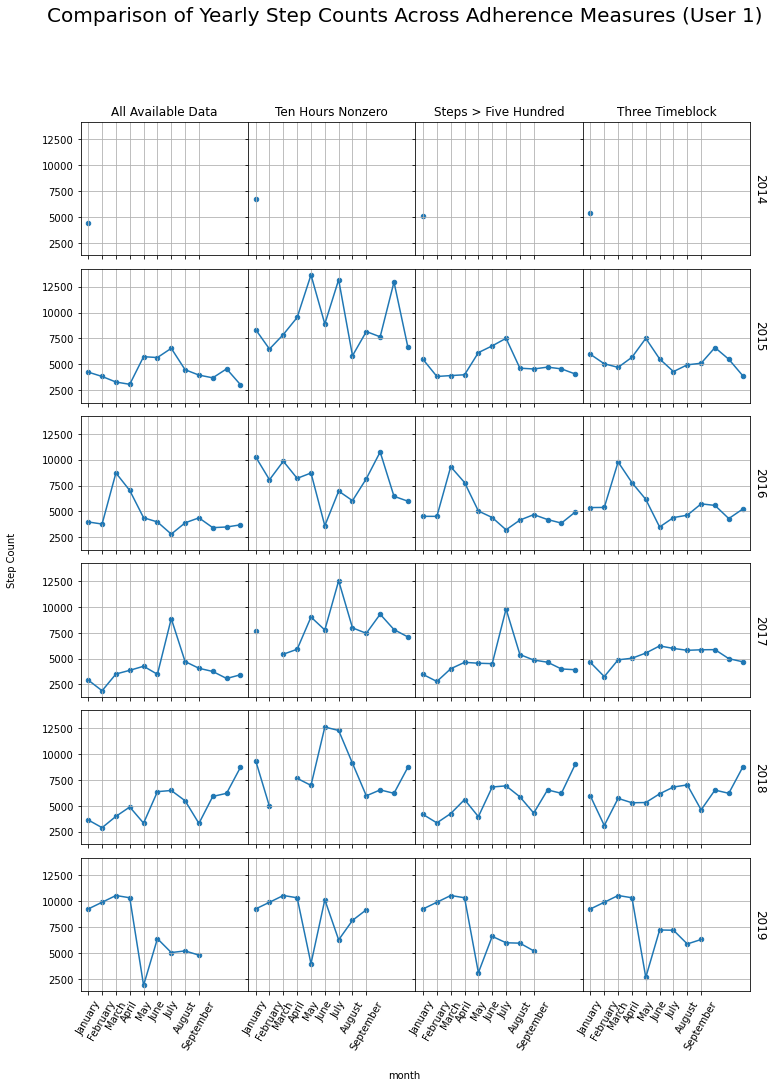

In [89]:
user_comparisons(dfs[0], 'User 1')

This GIANT plot compares the average steps per month for each year, with each column representing a difference adherence filter: from left to right, we see aggregated steps for the full dataset, ten nonzero hours filter, greater than 500 filter, and the three timeblocks filter.

Immediately, it's apparrent that filtering for at least ten hours of nonzero steps roundabouts doubles the average step count, which is partially to be expected as it filters out many days of zeroes. How much the baseline step activity shifts up by depends on the level of consistency in their activity-- User1 seems to have many days of no activity, perhaps because they didn't carry their phone around with them, or perhaps they didn't move much.

The >500 Steps and Three Timeblocks filters evidently don't remove as many days of low step counts as Ten Nonzero. Especially interesting to note is that the Three Timeblocks filter appears to smooth out the user's activity over the year, as it tests for days where the user consistently walked over the course of the day-- i.e. didn't go on a one hour run and then stayed home for the rest of the day.

Given these graphs, we find the following trends for User1 over the time period:
- 2015: They didn't have their phone consistently for many days, but on the days that they did consistently wear the tracker, they walked around 10,000 steps a day. May and October had the highest consistent activity levels, but the May - July period had more bursts of high activity.
- 2016: Walking peaked in March and steadily declined from there, with June having particularly low tracking time despite having average step counts
- 2017: Not a single day of more than 10 hours of nonzero step count in February, which suggests they may not have gone outside much over that month, or didn't have access to their phone/tracker. They walked a lot and over many days in July but it was in a shorter amount of time (e.g. a hike and then went home and did nothing)
- 2018: March was a month of low wear time, but May through July still goes strong with high wear time and higher than average step counts.
- 2019: The user was far more consistent in tracking the whole day, given that the step counts look very similar across all adherence measures. This year, March to April emerge as their most active months, with May through July characterised by a sharp fall in walking

---


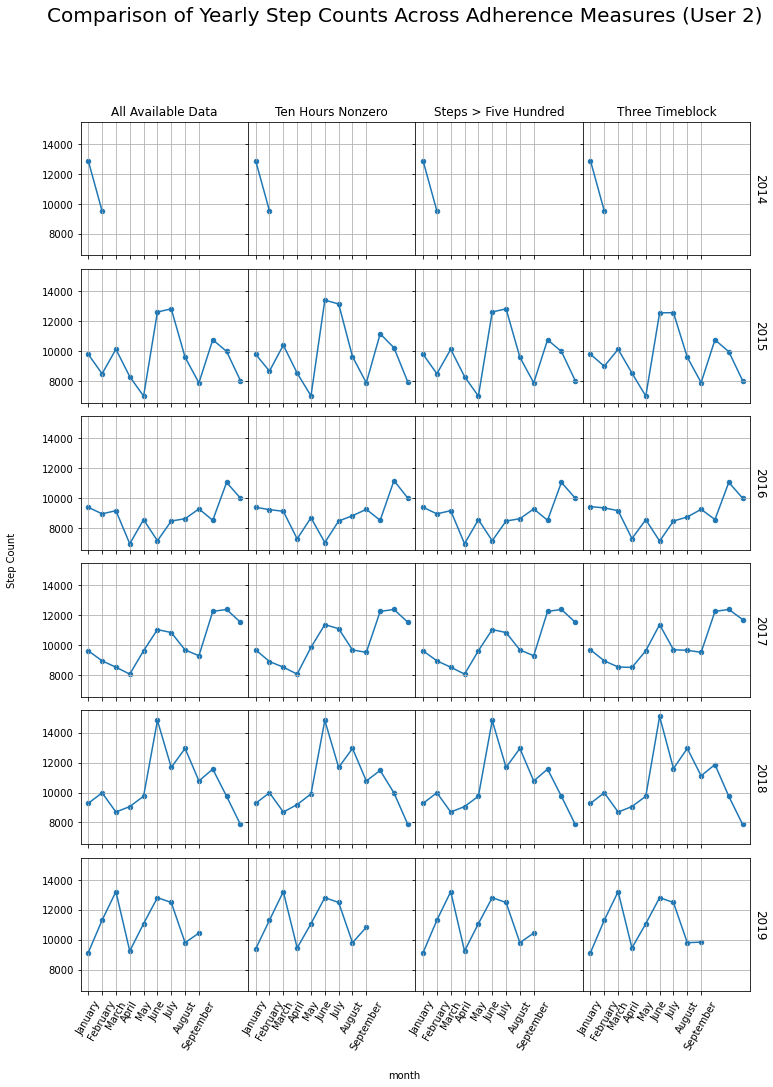

In [90]:
user_comparisons(dfs[1], 'User 2')

Now, for User 2, differences between the adherence measures are much less pronounced, which suggest that the original Althoff et al adjustments are indeed an accurate picture of their actual activity data, in that the user has high adherence and significant step counts.

User 2 represents a user for whom Althoff et al and other current methods of step tracking work very well for. 

---

We will now show another user for whom the default method doesn't work well for.

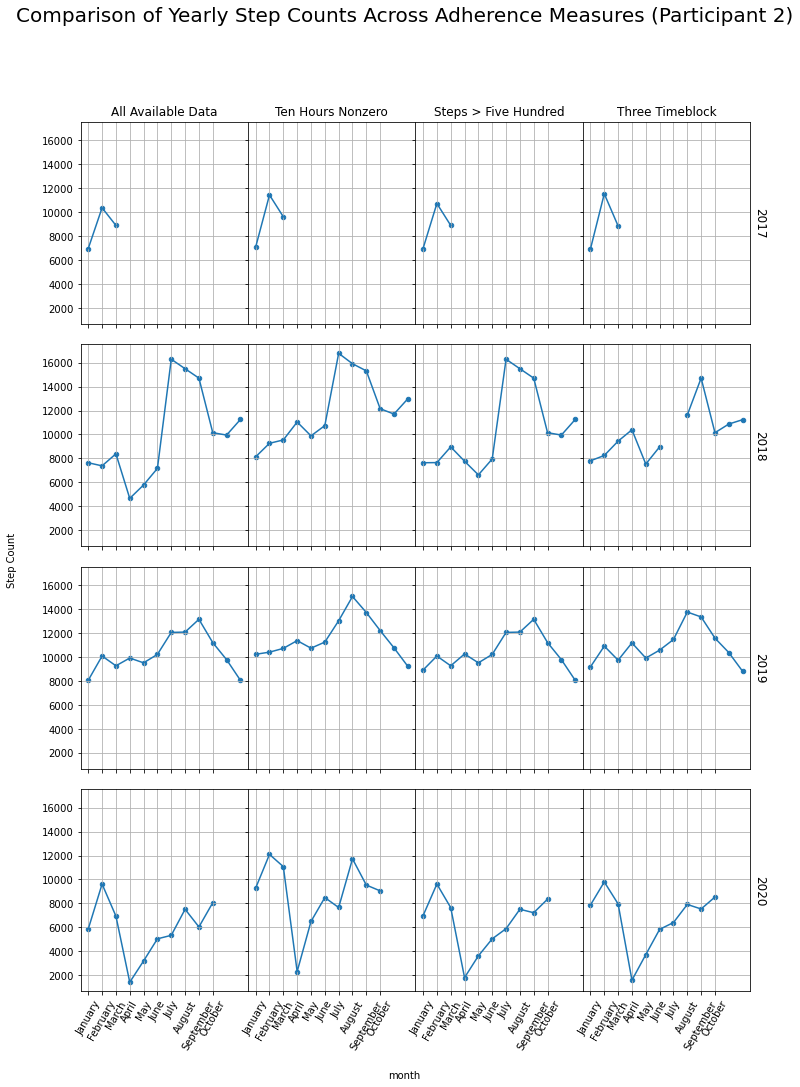

In [91]:
user_comparisons(dfs[3], 'Participant 2')

Drawing attention to the 2018 average step counts, we can see that the original Althoff et al method will skew all step counts downwards due to the larger number of nonzeroes. While it looks like they exercised consistently and a lot in July, using the 3 Timeblocks we can see that they weren't actually tracking for the full day at all in July. 

Using the 10 hour nonzero method, we also get a better idea of the user's baseline level of activity, whch is around 10,000 steps in 2018 rather than the 8000 that the Althoff method implies. 

This trend persists across the years.




### Example Implementation of (S)ARIMA
To determine which **Step Count** method is the best, we decided to use the **(S)ARIMA** forecasting method to study which Step count method would produce the best prediction. In addition to observing how closely the prediction is to the actual data, we observed the **RMSE** values produced by each of the step count methods. The brief outline of the SARIMA process will be shown here. For each Participant data and **Adherence Filter**, **three (3) Step Count Methods** were applied to each of them and their **Prediction** and **RMSE** values were noted in order for us to perform our analysis.

### Modified Function to combine the Adherence Filter and Step Count Methods

In [92]:
def modified_calculate_daily_steps(df, filter_measure, start_time, end_time): 
    filtered_df = filter_by_adherence(df, filter_measure)
    
    dailysteps_method2 = top_ten_most_active_hours(filtered_df)
    dailysteps_method1 = all_step_activity(filtered_df)
    dailysteps_method3 = ten_hour_time_block(filtered_df, start_time, end_time)
    
   
    return dailysteps_method1,dailysteps_method2,dailysteps_method3

Here, we created a modified version of the calculate_daily_steps() function. However, instead of returning a table containing the date and the various methods of calculating steps, this function returns the steps as values
### Load Data

In [93]:
filter_measure = 1
start_time = 8
end_time = 18

ds_method1, ds_method2, ds_method3 = modified_calculate_daily_steps(dfs[4], filter_measure, start_time, end_time)

In the cell above, **filter_measure** can have the value 1, 2, 3 or 4 to select which adherence measure we would like to use. As we have decided that the start and end time be 8am and 6pm daily.
The Last line above, creates three (3) values ds_method1, ds_method2 and ds_method3 respective to their methods of counting steps

In [94]:
# Converting the Date column to the index
ds_method1.set_index('Date',inplace=True)

# Steps to take to implement (S)ARIMA

1) Check for Seasonality <br />
2) Check for Stationarity <br />
3) If not Stationary perform Rolling/ Smoothing/ Shifting/ Differentiation <br />
4) Obtain SARIMA Parameters <br />
5) Data Splitting and Model Evaluation <br />
6) Model Prediction

## Why is SARIMA Important?
For each participant, we have conducted SARIMA modelling to predict their respective future step count values. This is important, as we are making the assumption that our participants follow routines, and that repetitive past behaviours would be reflected in future behaviours. Given that our driving question is to determine different ways to calculate 10-hrs of steps, using SARIMA allows for us to account for seasonality, remove "random white noise" and based on the prediction compare it against the Althoff’s  calculation of step counts. 

Our goal is to firstly, find a method that produces the **lowest Root Mean Square Errors (RMSE)**, and secondly determine the **best performing adherence measure**. For every participant, we have computed the respective RMSE of their SARIMA models for each applied method and adherence measure. 

#### Note: No model was done for Participant 1, 4, 6 and 7 due to a lack of substantial data (ie. too many zero step counts, not enough rows) after passing through our adherence check. 

Below is an example of our approach for Participant 2

## All Step activity (Step Count Method 1)
### 1) Check For Seasonality
##### Simple Plot

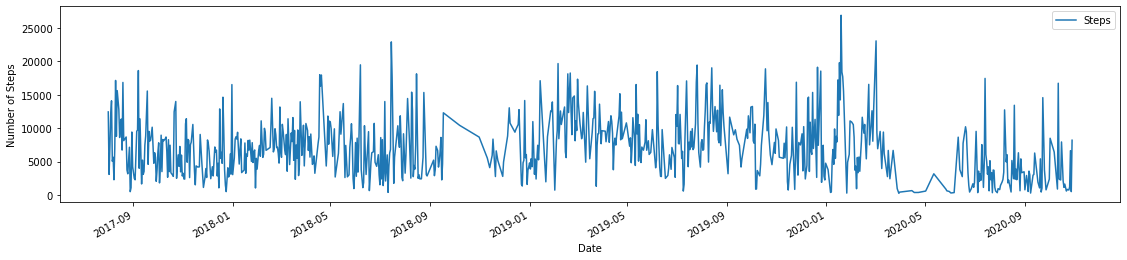

In [95]:
ds_method1.plot(figsize=(19, 4))
plt.ylabel("Number of Steps")
plt.show()

It does appear to have some form of seasonality, besides between 2018-09 to 2019-01 and 2020-05 to 2020-09. I suspect this is due to the adherence measure that removed a large portion of the observations during these dates. <br />
#### Seasonal Decompose Plot
Using the command, we can decompose the time series into three distinct components: Trend, Seasonality and noise

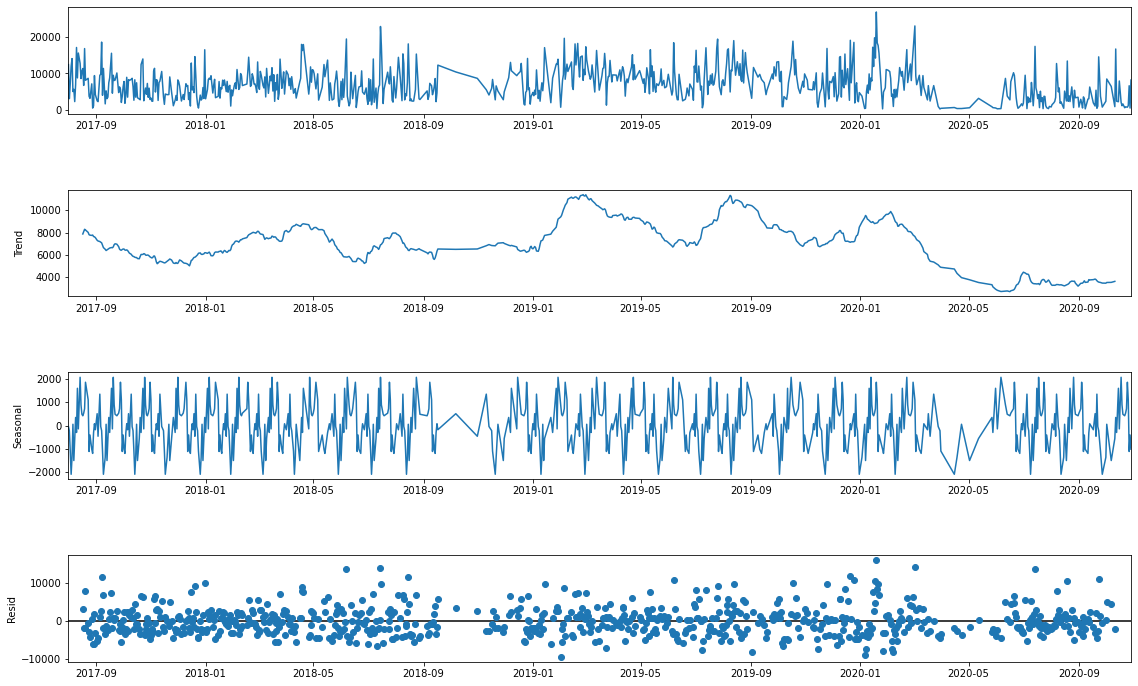

In [33]:
decomposition = sm.tsa.seasonal_decompose(ds_method1, model='additive', period = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

After adherence, it appears that the data does have some form of Seasonality over the years besides certain year-gaps. As such, we will employ the SARIMA here instead of ARMIA <br />
### 2) Check for data Stationarity
Will use this function to test for stationarity by using the **Augmented Dickey-Fuller test** <br />
where <br />
$H_0$: If failed to be rejected, time series data is not stationary <br />
$H_1$: If $H_0$ is rejected, it means the time series data is stationary



In [34]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel("Date")
    plt.xticks(rotation = 'vertical')
    plt.ylabel("Number of Steps")
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Steps'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

This function produces a graph of the data together with the rolled mean and standard deviation of the data. The **Rolled Mean** and **Rolled Standard Deviation** are the smoothened data making observation of the data across the time series period easier for observation. <br />
In addition to the graph, this function performs the **Augmented Dickey Fuller Test** which allows us to check if the data is stationary (as it is one (1) of the requirements to perform SARIMA. 

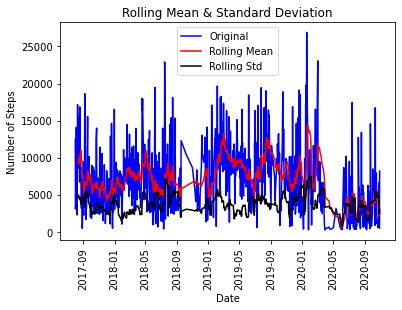

Results of Dickey Fuller Test:
ADF Test Statistic              -5.382365
p-value                          0.000004
#Lags Used                       9.000000
Number of Observations Used    763.000000
Critical Value (1%)             -3.438950
Critical Value (5%)             -2.865335
Critical Value (10%)            -2.568791
dtype: float64


In [35]:
test_stationarity(ds_method1)

For this, we will use the $\alpha$ value of 0.05 to check against the p-value of 0.000004 to decide if we will accept or reject the $H_0$.<br />
We can observe that $\alpha$ > p-value, we can conclude that the data is stationary.

### 3) Data Transformation

As we have concluded that the data is stationary, no data transformation was required

### 4) SARIMA Parameter Selection
SARIMA has parameters **(p,d,q)(P,D,Q)[m]** <br />
The first three (3) are the non-seasonal parameters (p,d,q) <br />
while the next four (4) are the seasonal parameters (P,D,Q)[m] <br />
p: The lag order of the model (the number of lags observed in the model <br />
d: The number of times the data is required to be differentiated to obtain stationarity <br />
q: The size of the moving average window <br />
P: Seasonal Autoregressive Order <br />
D: Seasonal Difference Order <br />
Q: Seasonal Moving Average order <br />
m: the number of steps for a single **seasonal** period 
#### ACF and PACF plots

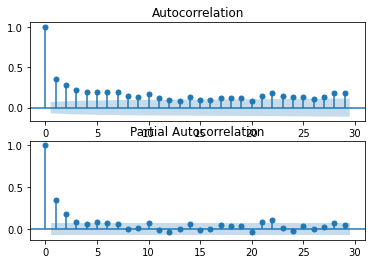

In [36]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method1, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ds_method1, ax=ax[1])
plt.show()

The Partial-Autocorrelation plot is used to select the parameters of p and P we can observe that the ACF plot appears to 'die out' around the 10th lag while in the PACF graph, we can observe that the lags does this around the 2nd lag indicating our estimate of p = 2 <br />
We know that d = 0 as no differentiation was needed to make the data stationary <br />
The Auto-ARIMA Process allows for the selection of the (S)ARIMA parameters more easily. It will be employed in the following cell

In [37]:
stepwise_model = auto_arima(ds_method1, start_p=0, start_q=0,
                           max_p=2, max_q=10, m=12,
                           start_P=0,start_Q=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=15195.575, BIC=15204.876, Fit time=0.237 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=15095.726, BIC=15114.327, Fit time=0.617 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=15126.556, BIC=15145.157, Fit time=0.386 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=15094.490, BIC=15108.441, Fit time=0.155 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=15095.676, BIC=15114.277, Fit time=0.491 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=15097.632, BIC=15120.884, Fit time=1.672 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=15070.081, BIC=15088.682, Fit time=0.288 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=15069.863, BIC=15093.114, Fit time=0.415 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(1, 0, 0, 12); AIC=15071.748, BIC=15099.650, Fit time=1.119 seconds
Fit ARIMA:

The **Auto-ARIMA** selects the best parameters for the SARIMA based on a range of values that can be set when defining the function.
In this case, the **Auto-ARIMA** has selected the model ARIMA(2,0,1)(1,0,0)[12] based on the alrged **AIC** value
### ACF and PACF Residuals
Next, we fitted the residuals into the ACF and PACF graph to check for any sign of autocorrelation

Optimization terminated successfully.
         Current function value: 9.732948
         Iterations: 7
         Function evaluations: 408


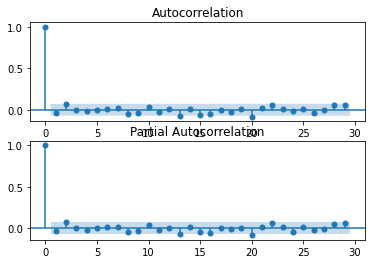

In [38]:
model = sm.tsa.statespace.SARIMAX(ds_method1, order=(2,0,1), seasonal_order = (1,0,0,12)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, ax=ax[1])
plt.show()

From here, we observed that there does not appear to be any signs of autocorrelation so we will continue <br />
### 5) Data Splitting & Model Evaluation
Fitting the model train and test data. The train data contains 80% of the data and the test data contains 20% of the data

In [39]:
train = ds_method1.loc['2017-08-01':'2020-01-18']
test = ds_method1.loc['2020-01-19':]
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(2, 0, 4),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 0, 1, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

### Model Summary

In [40]:
mod = sm.tsa.statespace.SARIMAX(ds_method1,
                                order=(2, 0, 1),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Steps   No. Observations:                  773
Model:             SARIMAX(2, 0, 1)x(1, 0, [], 12)   Log Likelihood               -7385.353
Date:                             Wed, 18 Nov 2020   AIC                          14780.706
Time:                                     15:18:44   BIC                          14803.866
Sample:                                          0   HQIC                         14789.625
                                             - 773                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1825      0.044     26.884      0.000       1.096       1.269
ar.L2         -0.1840      

Some of the statistical values of the model can be observed form above. The SARIMA model with parameters (2, 0, 1)(1, 0, 0)[12] was fitted and the summary above. It obtained an AIC of 14780.706. As the AIC is reletively high, we can note that the model isn't too accurate

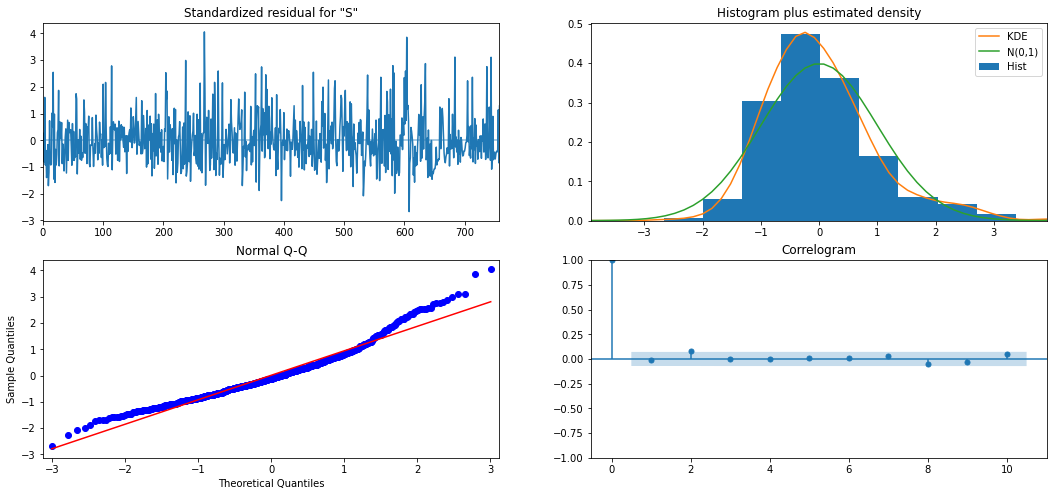

In [41]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

Distribution of the data appears normal, No indication of autocorrelation and the Q-Q plot pints are quite close to the normal. A log transformation improve fix this.
### (S)ARIMA Model Validation

In [42]:
# the 20% point test data is on the specified date below
split_date = '2020-01-18'
data = ds_method1['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(2, 0, 1),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)

pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae1 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse1 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse1 = math.sqrt(mse1)
print(f'Mean Squared Error: {mse1.round(4)}')
print(f'Root Mean Squared Error: {round(rmse1,4)}')
print(f'Mean Absolute Error: {mae1.round(4)}')

Mean Squared Error: 34134972.3883
Root Mean Squared Error: 5842.5142
Mean Absolute Error: 5143.2049


### 6) Model Prediction

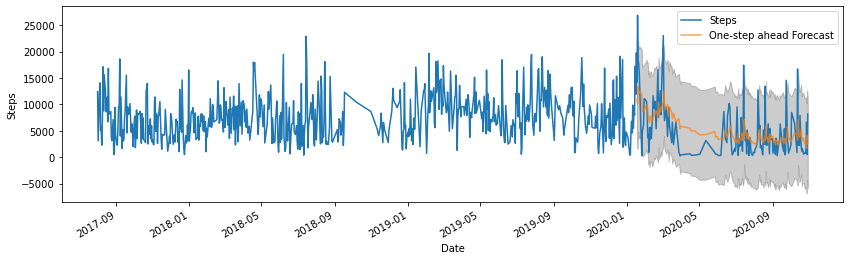

In [43]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-18'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method1['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Steps')
plt.legend()
plt.show()

Model does not perform very well around 2020-05. Might be due to the adherence measure that removed quite a lot of user data during this time period
## Top Ten Most Active Hours  (Step Count Method 2)

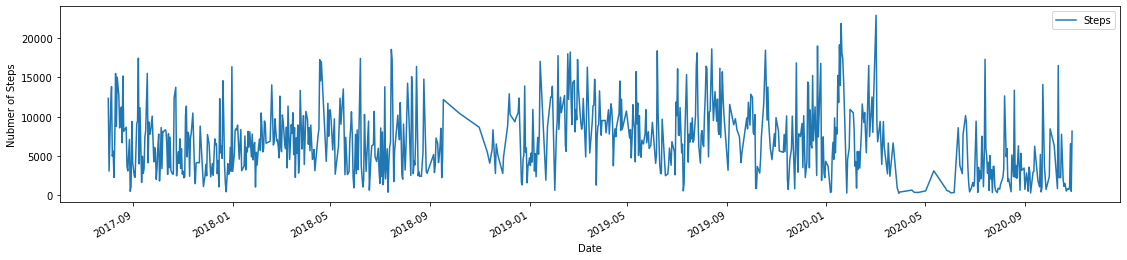

In [44]:
ds_method2.set_index('Date',inplace=True)
ds_method2.plot(figsize=(19, 4))
plt.ylabel("Nubmer of Steps")
plt.show()

The chart does appear to have some form of seasonality besides from 2018-09 to 2019-01 and 2020-05 and 2020-09 where there does not appear to be any data. Similar to earlier, this is due to the adherence measure employed. 

### 1) Check for Seasonality

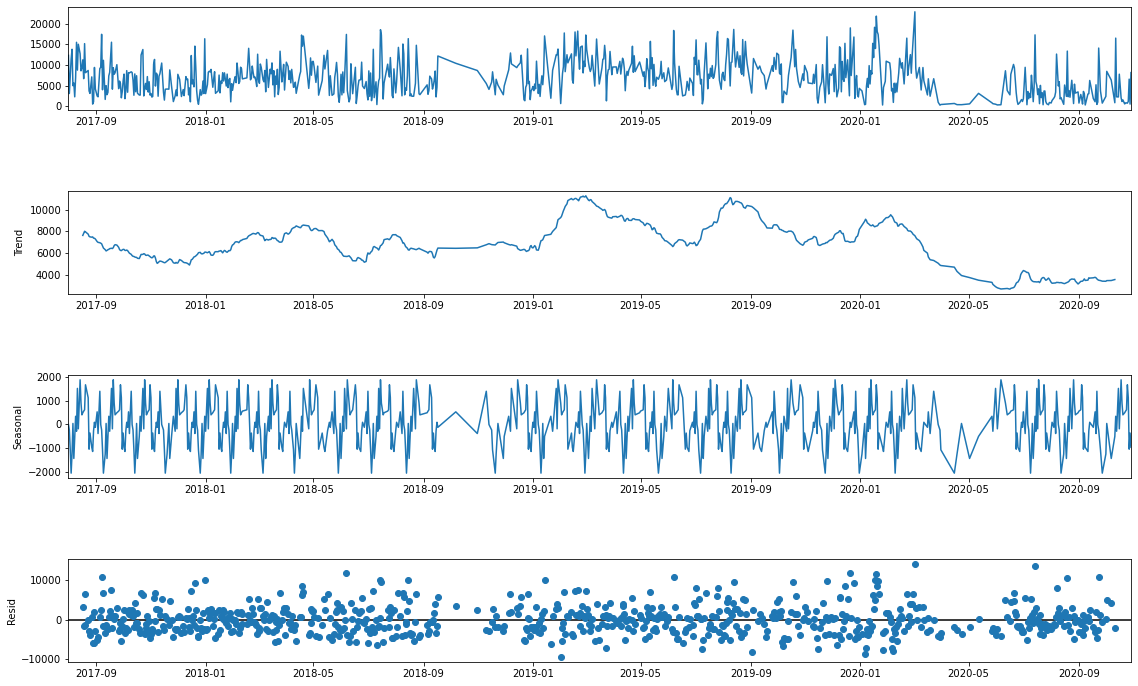

In [45]:
decomposition = sm.tsa.seasonal_decompose(ds_method2, model='additive', period = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

Again, there does appear to be some form of seasonality besides the two (2) points where there appear to be a lack of data. As such, we will employ the use of SARIMA instead of ARIMA to account for seasonality

### 2) Check for Stationarity

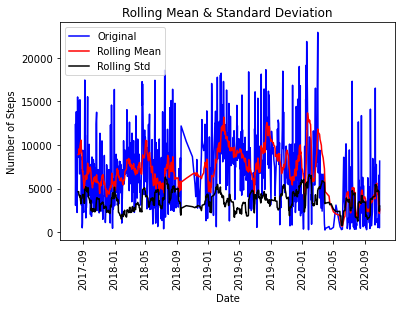

Results of Dickey Fuller Test:
ADF Test Statistic              -5.272064
p-value                          0.000006
#Lags Used                       9.000000
Number of Observations Used    763.000000
Critical Value (1%)             -3.438950
Critical Value (5%)             -2.865335
Critical Value (10%)            -2.568791
dtype: float64


In [46]:
test_stationarity(ds_method2)

For this, we will use the $\alpha$ value of 0.05 to check against the p-value of 0.000006 to decide if we will accept or reject the $H_0$. As $\alpha$ > p-value, we can conclude that the data is stationary.

### 3) Data Transformation

As we have concluded that the data is stationary, no data transformation was required

### 4) Obtain SARIMA Parameters

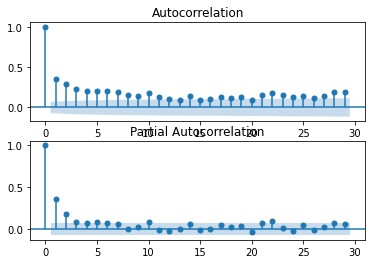

In [47]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method2, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ds_method2,ax=ax[1])
plt.show()

Like earlier, the PACF graph is used to determine the estimated p value which appears to be 2 in this case. While the q value is usually estimated to be around the same value as p. The d = 0 as no differenciation was required.

In [48]:
stepwise_model = auto_arima(ds_method2, start_p=0, start_q=0,
                           max_p=2, max_q=2, m=12,
                           start_P=0,start_Q=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=15142.217, BIC=15151.517, Fit time=0.043 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=15038.891, BIC=15057.492, Fit time=0.653 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=15070.711, BIC=15089.312, Fit time=0.368 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=15037.833, BIC=15051.784, Fit time=0.100 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=15038.827, BIC=15057.428, Fit time=0.332 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=15040.773, BIC=15064.025, Fit time=1.270 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=15013.101, BIC=15031.703, Fit time=0.164 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=15012.748, BIC=15035.999, Fit time=0.301 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(1, 0, 0, 12); AIC=15014.666, BIC=15042.568, Fit time=0.761 seconds
Fit ARIMA:

#### Residuals of ACF and PACF

Optimization terminated successfully.
         Current function value: 9.695049
         Iterations: 4
         Function evaluations: 192


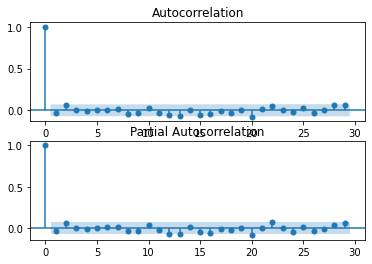

In [49]:
model = sm.tsa.statespace.SARIMAX(ds_method2, order=(2,0,1), seasonal_order = (0,0,0,12)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res,  ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res,  ax=ax[1])
plt.show()

By employing the model, it appears that Autocorrelation is not an issue by selecting these parameters

### 5) Data Splitting and Model Evaluation

In [50]:
train = ds_method2.loc['2017-08-01':'2020-01-18']
test = ds_method2.loc['2020-01-19':]
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 0, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(2, 0, 2, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

In the cell above, I fitted the model based on those dates. I set the train data to be 80% of the total data and test data to be 20% of the entire data before fitting the train data in a stepwise model.

In [51]:
mod = sm.tsa.statespace.SARIMAX(ds_method2,
                                order=(2,0,1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Steps   No. Observations:                  773
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -7476.965
Date:                Wed, 18 Nov 2020   AIC                          14961.929
Time:                        15:20:29   BIC                          14980.520
Sample:                             0   HQIC                         14969.083
                                - 773                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1661      0.042     27.670      0.000       1.084       1.249
ar.L2         -0.1684      0.042     -3.988      0.000      -0.251      -0.086
ma.L1         -0.9137      0.017    -52.971      0.0

The SARIMA(2,0,1)(0, 0, 0)[12] model summary above with an AIC of 14961.929

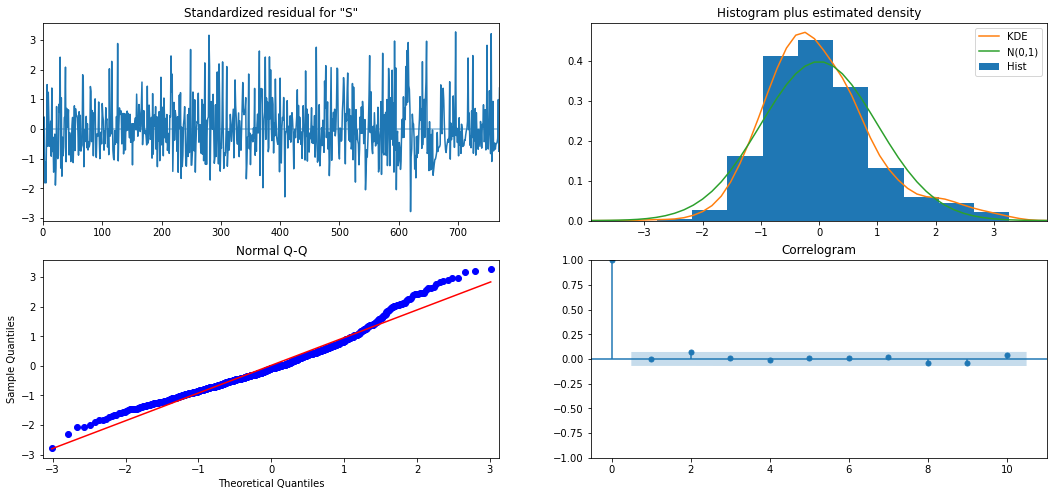

In [52]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

Some plots. We can observe that the data observes a reletively normal distribution, no Autocorrelation is observed, The points on the Q-Q plot are close to the line indicating a good fit
### Model Validation

In [53]:
# the 20% point test data is on the specified date below
split_date = '2020-01-18'
data = ds_method2['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(2,0, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)
pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae2 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse2 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse2 = math.sqrt(mse2)
print(f'Mean Squared Error: {mse2.round(4)}')
print(f'Root Mean Squared Error: {round(rmse2,4)}')
print(f'Mean Absolute Error: {mae2.round(4)}')

Mean Squared Error: 29781709.6414
Root Mean Squared Error: 5457.2621
Mean Absolute Error: 4808.6521


### 6) Model Prediction

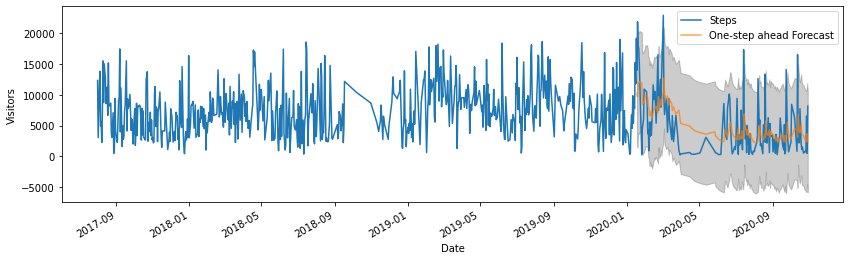

In [54]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-18'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method2['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Visitors')
plt.legend()
plt.show()

The prediction isnt very good around the 2020-05 area. This could be due to the removed data chunks removing information that would allow the model to train.
### Ten Hour Time Block (Step Count Method 3)

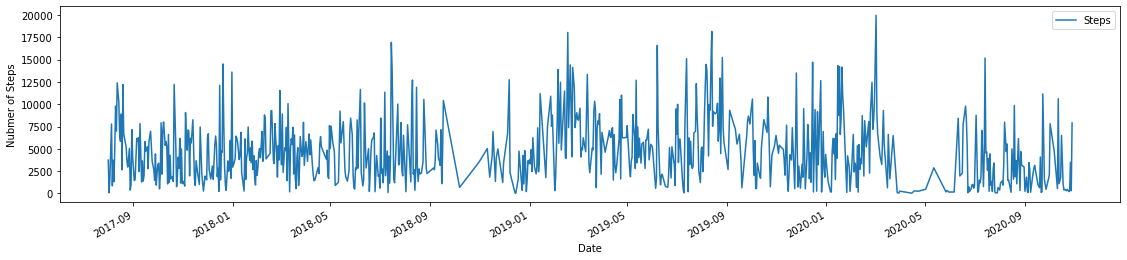

In [55]:
ds_method3.set_index('Date',inplace=True)
ds_method3.plot(figsize=(19, 4))
plt.ylabel("Nubmer of Steps")
plt.show()

### 1) Check for Seasonality

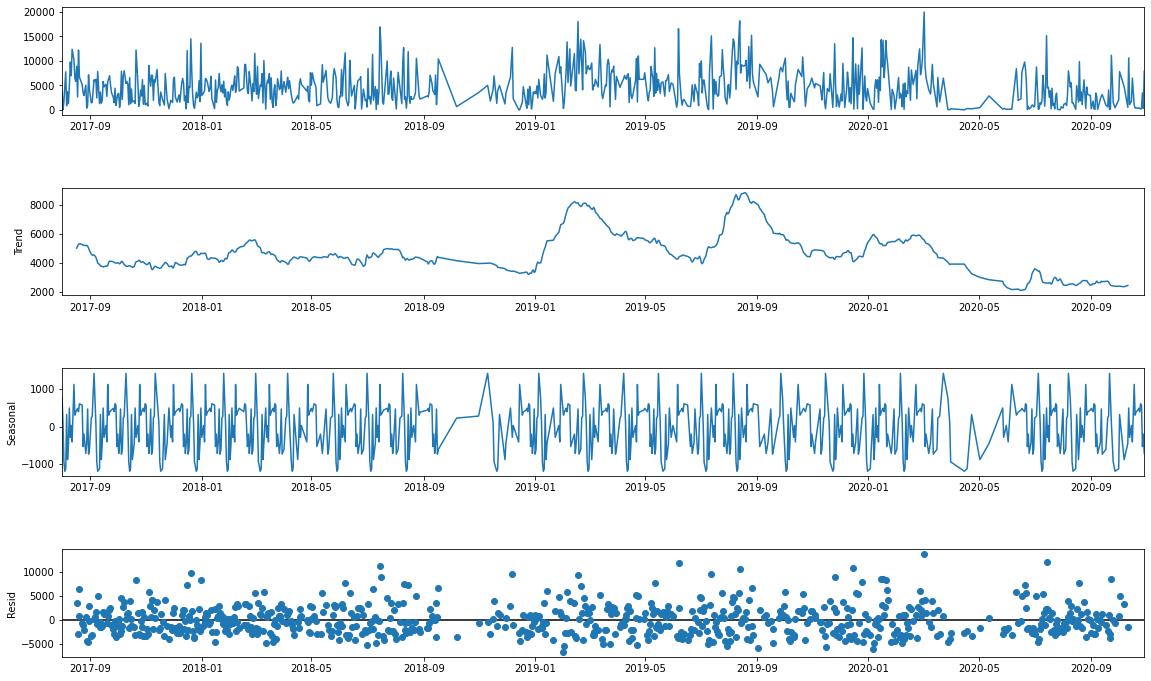

In [56]:
decomposition = sm.tsa.seasonal_decompose(ds_method3, model='additive', period = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

As Expected, the data appears to be seasonal besides those 2 periods. So the SARIMA would be used again

### 2) Check for Stationarity

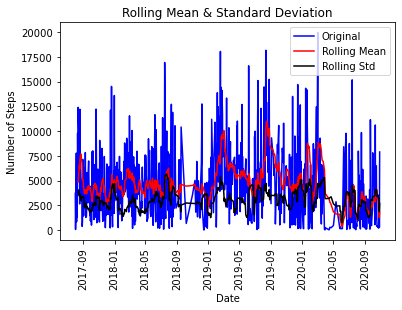

Results of Dickey Fuller Test:
ADF Test Statistic            -6.792812e+00
p-value                        2.341232e-09
#Lags Used                     6.000000e+00
Number of Observations Used    7.660000e+02
Critical Value (1%)           -3.438916e+00
Critical Value (5%)           -2.865321e+00
Critical Value (10%)          -2.568783e+00
dtype: float64


In [57]:
test_stationarity(ds_method3)

For this, we will use the $\alpha$ value of 0.05 to check against the p-value of 2.341232e-09 to decide if we will accept or reject the $H_0$. As $\alpha$ > p-value, we can conclude that the data is stationary.
### 3) Data Transformation
As we have concluded that the data is stationary, no data transformation was required
### 4) Obtain SARIMA Parameters

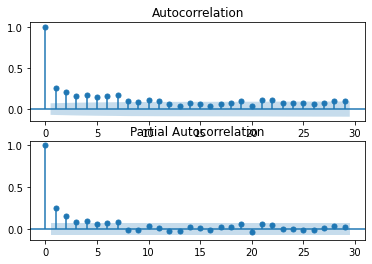

In [58]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method3,  ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ds_method3,  ax=ax[1])
plt.show()

In [59]:
stepwise_model = auto_arima(ds_method3, start_p=0, start_q=0,
                           max_p=7, max_q=10, m=12,
                           start_P=0,start_Q=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=14829.888, BIC=14839.189, Fit time=0.051 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=14782.183, BIC=14800.784, Fit time=0.754 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=14794.966, BIC=14813.567, Fit time=0.515 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=14780.671, BIC=14794.622, Fit time=0.140 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=14782.091, BIC=14800.692, Fit time=0.516 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=14784.079, BIC=14807.330, Fit time=1.712 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=14764.287, BIC=14782.888, Fit time=0.231 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=14764.393, BIC=14787.645, Fit time=0.436 seconds
Fit ARIMA: order=(3, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=14762.052, BIC=14789.953, Fit time=0.416 seconds
Fit ARIMA:

#### Residuals of ACF and PACF

Optimization terminated successfully.
         Current function value: 9.554514
         Iterations: 1
         Function evaluations: 97


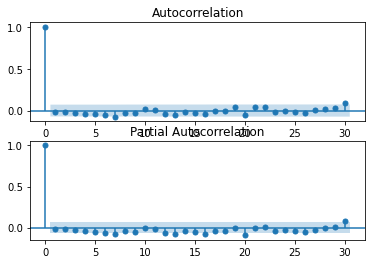

In [60]:
model = sm.tsa.statespace.SARIMAX(ds_method3, order=(7,0,0), seasonal_order = (0,0,0,12)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, lags=30, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=30, ax=ax[1])
plt.show()

Autocorrelation of the residuals do not appear to be present
### 5) Data Splitting and Model Evaluation

In [61]:
train = ds_method3.loc['2017-08-01':'2020-01-18']
test = ds_method3.loc['2020-01-19':]
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(7, 0, 0),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

### Fitting the model based on the selected parameters

In [62]:
mod = sm.tsa.statespace.SARIMAX(ds_method3,
                                order=(7,0,0),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Steps   No. Observations:                  773
Model:               SARIMAX(7, 0, 0)   Log Likelihood               -7319.043
Date:                Wed, 18 Nov 2020   AIC                          14654.086
Time:                        15:21:22   BIC                          14691.215
Sample:                             0   HQIC                         14668.379
                                - 773                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2308      0.034      6.750      0.000       0.164       0.298
ar.L2          0.1590      0.036      4.471      0.000       0.089       0.229
ar.L3          0.0975      0.037      2.637      0.0

The SARIMA(7,0,0)(0, 0, 0)[12] model summary above with an AIC of 14654.086

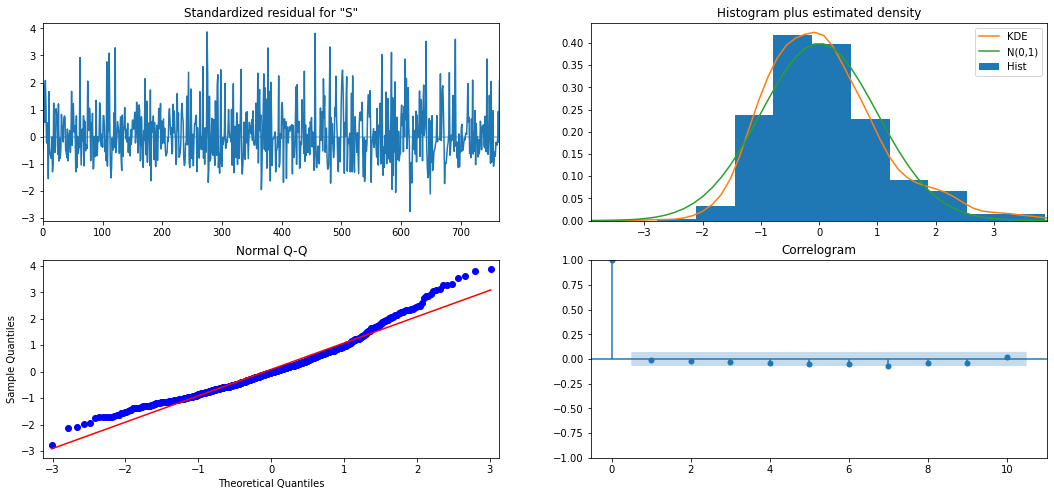

In [63]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

Distribution of the data appears normal, No indication of autocorrelation and the Q-Q plot pints are quite close to the normal. A log transformation might improve this.

### Model Validation

In [64]:
# the 20% point test data is on the specified date below
split_date = '2020-01-18'
data = ds_method3['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(7,0,0),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)
pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae3 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse3 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse3 = math.sqrt(mse3)
print(f'Mean Squared Error: {mse3.round(4)}')
print(f'Root Mean Squared Error: {round(rmse3,4)}')
print(f'Mean Absolute Error: {mae3.round(4)}')

Mean Squared Error: 13044691.042
Root Mean Squared Error: 3611.7435
Mean Absolute Error: 2824.8349


### 6) Model Prediction

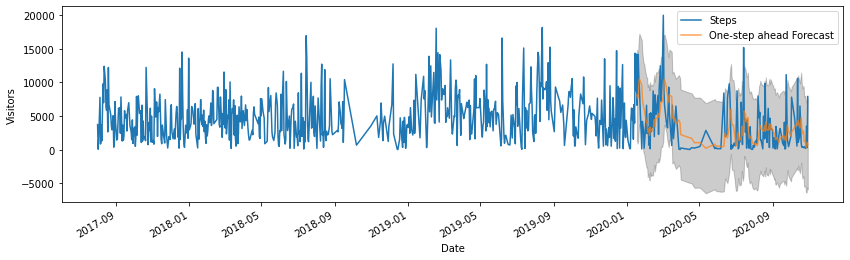

In [65]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-18'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method3['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Visitors')
plt.legend()
plt.show()

Method 3's Step calculation allows for quite a good prediction

### Comparing all three (3) Step Count Methods

In [66]:
models = pd.DataFrame({
    'Method': ['Top Ten Most Active Hours', 'All Step Activity', 'Ten Hour Time Block'],
    'MSE': [round(mse1, 4), round(mse2, 4), round(mse3,4)],
    'RMSE': [round(rmse1,4 ), round(rmse2, 4), round(rmse3,4)],
    'MAE': [round(mae1, 4), round(mae2, 4), round(mae3,4)]})
models

,Method,MSE,RMSE,MAE
0,Top Ten Most Active Hours,3.413497e+07,5842.5142,5143.2049
1,All Step Activity,2.978171e+07,5457.2621,4808.6521
2,Ten Hour Time Block,1.304469e+07,3611.7435,2824.8349


Based on the above predictions, we can observe that **Method 3** had the best prediction and the **RMSE** value of **Model 3** is the lowest, therefore, we can conclude that the **Method 3** performs the best here.

Similar Steps were taken for every Participant ID and Adherence measure. Below, is a conclusion we have reached:

> Our findings have determined **method 3**, the ten hour time block, consistently produces the lowest RMSE. Secondly, that **adherence measure 4**, where our data has to pass the three timeblock, ten hours non zero steps, daily step count being greater than 500 checks, performs the best.

## Discussion

## Conclusion/Further Work

## Links and References